In [1]:
from src.utils import GtexSlide, GtexSample
from src.metrics import *
import src.modeling as md
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

>> Num GPUs Available:  1
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
>> Number of devices withing strategy: 1


# PART 0 - Define Parameters

In [2]:
import yaml
def get_parameters():
    with open("./conf/parameters.yml") as params:
        params_dict = yaml.safe_load(params)
    return params_dict

params = get_parameters()

In [3]:
#-------------------//-------------------

TISSUE_TYPE             = params["TISSUE_TYPE"]
IMAGES_PATH             = params["IMAGES_PATH"].format(TISSUE_TYPE)
SIZE                    = (params["SIZE"],params["SIZE"])
LEVEL                   = params["LEVEL"]
TISSUE_PERCENT          = params["TISSUE_PERCENT"]
TILES_FOLDER            = params["TILES_FOLDER"].format(SIZE[0], LEVEL, TISSUE_PERCENT)
NUM_PROCESSES           = params["NUM_PROCESSES"]
DOWNLOAD                = params["DOWNLOAD"]

#-------------------//-------------------

train_classes           = params["train_classes"]
validation_set          = params["validation_set"]
predefined_test_sample  = params["predefined_test_sample"]
model_type              = params["model_type"]
batch_size              = params["batch_size"]
learning_rate           = params["learning_rate"]
epochs                  = params["epochs"]
batch_size_test         = params["batch_size_test"]
augmentation            = params["augmentation"]
weighted                = params["weighted"]
multiplier_factor       = params["multiplier_factor"]
mlflow_exp_name         = params["mlflow_exp_name"]
model_suffix            = params["model_suffix"]

#-------------------//-------------------

PATH_TestSample         = params["PATH_TestSample"]

#-------------------//-------------------

# PART 1 - Download Images

## Selecting the Subject IDs (sid) to download

In [5]:
sample = GtexSample()
lt_sid = sample.get_subsample("Tissue", TISSUE_TYPE)

[+] Found 860 subjects for Lung


### If you wanna see some attributes of a specific subject

In [8]:
sample.database.query("subject_id == 'GTEX-12696'")

,sample_id,Tissue,subject_id,Sex,Age Bracket,Hardy Scale,Pathology Categories,Pathology Notes
1635,GTEX-12696-0126,Skin - Not Sun Exposed (Suprapubic),GTEX-12696,male,60-69,Intermediate death,NaN,"6 pieces, minimal dermal fat; squamous epithel..."
1636,GTEX-12696-0226,Testis,GTEX-12696,male,60-69,Intermediate death,spermatogenesis,"2 pieces, mild-moderate autolysis, focally app..."
1637,GTEX-12696-0326,Thyroid,GTEX-12696,male,60-69,Intermediate death,NaN,"2 pieces, regressive changes"
1638,GTEX-12696-0426,Artery - Aorta,GTEX-12696,male,60-69,Intermediate death,atherosis,"6 pieces, minimal atherosis, adherent serosa u..."
1639,GTEX-12696-0526,Artery - Coronary,GTEX-12696,male,60-69,Intermediate death,"atherosis, calcification","2 pieces, mild (20%) occlusive atherosis, foca..."
1640,GTEX-12696-0626,Adrenal Gland,GTEX-12696,male,60-69,Intermediate death,clean_specimens,"2 pieces, all cortex, good specimens, minimal fat"
1641,GTEX-12696-0726,Spleen,GTEX-12696,male,60-69,Intermediate death,NaN,"2 pieces, well-preserved"
1642,GTEX-12696-0826,Liver,GTEX-12696,male,60-69,Intermediate death,congestion,"2 pieces, moderate congestion; no significant ..."
1643,GTEX-12696-0926,Kidney - Cortex,GTEX-12696,male,60-69,Intermediate death,NaN,"6 pieces, all cortex; glomeruli present"
1644,GTEX-12696-1026,Lung,GTEX-12696,male,60-69,Intermediate death,congestion,"2 pieces, moderate congestion"


In [9]:
GtexSlide("GTEX-12696-0126", IMAGES_PATH).attributes

[+] Tile path created.


{'GTExPortal': {'sample_id': 'GTEX-12696-0126',
  'Tissue': 'Skin - Not Sun Exposed (Suprapubic)',
  'subject_id': 'GTEX-12696',
  'Sex': 'male',
  'Age Bracket': '60-69',
  'Hardy Scale': 'Intermediate death',
  'Pathology Categories': nan,
  'Pathology Notes': '6 pieces, minimal dermal fat; squamous epithelium is ~50 microns'},
 'pathologies': {'atrophy': 0,
  'clean_specimens': 0,
  'cyst': 0,
  'edema': 0,
  'sweat_glands': 0},
 'smoker_status': 'Smoker'}

In [6]:
sid_example = lt_sid[20]
sl_example = GtexSlide(sid_example, IMAGES_PATH)
sl_example.attributes

[+] Tile path created.


{'GTExPortal': {'sample_id': 'GTEX-11EQ8-1526',
  'Tissue': 'Lung',
  'subject_id': 'GTEX-11EQ8',
  'Sex': 'male',
  'Age Bracket': '60-69',
  'Hardy Scale': 'Slow death',
  'Pathology Categories': 'calcification, emphysema, hemorrhage, macrophages',
  'Pathology Notes': '2 pieces, some hemosiderin-laden macrophages, emphysematous change, area of hemorrhage and foci of calcified material, isolated fragment of skeletal muscle (? aspiration)'},
 'pathologies': {'atelectasis': 0,
  'calcification': 1,
  'clean_specimens': 0,
  'congestion': 0,
  'desquamation': 0,
  'edema': 0,
  'emphysema': 1,
  'fibrosis': 0,
  'heart_failure_cells': 0,
  'hemorrhage': 1,
  'hyalinization': 0,
  'hyperplasia': 0,
  'hypertrophy': 0,
  'inflammation': 0,
  'macrophages': 1,
  'metaplasia': 0,
  'necrosis': 0,
  'no_abnormalities': 0,
  'pigment': 0,
  'pneumonia': 0,
  'sclerotic': 0},
 'smoker_status': 'Smoker'}

### If you wanna see the intersection between tissues

In [4]:
lt_tissues = ["Lung", "Esophagus - Mucosa", "Pancreas", "Thyroid"]

[+] Found 860 subjects for Lung
[+] Found 963 subjects for Esophagus - Mucosa
[+] Found 865 subjects for Pancreas
[+] Found 902 subjects for Thyroid


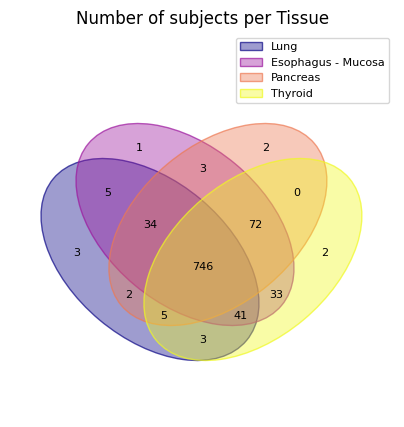

In [5]:
sample = GtexSample()
sample.compare_subsamples("Tissue", lt_tissues)

## Downloading tiles

In [8]:
def main(sid):
    sl = GtexSlide(sid, IMAGES_PATH)

    lt_folders = os.listdir(sl.tile_path)

    if len(lt_folders) == 0 or TILES_FOLDER not in lt_folders:
        sl.get_wsi()
        sl.break_into_tiles(level=LEVEL, size=SIZE, tissue_percent=TISSUE_PERCENT, thumb=True)
        sl.delete_wsi()
    else:
        print(f"[-] Tiles already exist for sid {sid}.")

def process_sid(sid):
    try:
        main(sid)
    except Exception as e:
        print(f"Error processing {sid}: {e}")

def run_parallel(sids, num_processes):
    with Pool(processes=num_processes) as pool:
        pool.map(process_sid, sids)

if DOWNLOAD:
    run_parallel(lt_sid, NUM_PROCESSES)

# PART 2 - Preprocessing

## Recovering tiles

Ensure IMAGES_PATH only contains folders with the sample_id as title. Do not leave there any other type of file.


In [9]:
lt_sid = os.listdir(IMAGES_PATH)

In [10]:
from tqdm import tqdm
lt_tiles = []
lt_error = []
for sid in tqdm(lt_sid):
    slide = GtexSlide(sid, IMAGES_PATH)
    try:
        lt = slide.get_tiles_path(TILES_FOLDER)
        smoker_status = slide.attributes["smoker_status"]
        lt_tiles.append(list(zip([sid]*len(lt), lt, [smoker_status]*len(lt))))
    except Exception as e:
        lt_error.append(sid)

print(f"[+] Sucefully loaded {len(lt_tiles)} sample ids")
print(f"[+] {len(lt_error)} sample ids were not identifyed.")

  0%|          | 0/860 [00:00<?, ?it/s]

100%|██████████| 860/860 [00:03<00:00, 283.62it/s]

[+] Sucefully loaded 385 sample ids
[+] 475 sample ids were not identifyed.


In [11]:
dfpd_tiles = pd.DataFrame(sum(lt_tiles, []), columns=["sample_id", "tile", "smoker_status"])

In [ ]:
dfpd_tiles.sample(5)

## Training, Validation and Test split

In [13]:
sample = GtexSample()

dfpd_samples = sample.database[sample.database.sample_id.isin(dfpd_tiles.sample_id.to_list())].copy()

assert dfpd_samples.shape[0] == len(lt_tiles)
assert dfpd_samples.Tissue.unique()[0] == TISSUE_TYPE

In [14]:
dict_smoker_status = (
    dfpd_tiles[["sample_id", "smoker_status"]]
        .drop_duplicates()
        .set_index("sample_id")
        .to_dict()
        )["smoker_status"]

dfpd_samples["smoker_status"] = dfpd_samples.sample_id.map(dict_smoker_status)

# Selecting only the classes of interest
dfpd_samples = dfpd_samples[dfpd_samples.smoker_status.isin(train_classes)].copy()
print(f'[+] Selected train classes: {train_classes} \n')

[+] Selected train classes: ['Smoker', 'Non Smoker'] 



In [ ]:
if predefined_test_sample:
    print('[+] ** Custom train sample selected ** \n')
    dfpd_samples_test = pd.read_csv(PATH_TestSample)

    lt_test_sid = dfpd_samples_test.sample_id.to_list()
    
    df_test = dfpd_samples[dfpd_samples.sample_id.isin(lt_test_sid)]
    df_train = dfpd_samples[~dfpd_samples.sample_id.isin(lt_test_sid)]

else:
    df_train, df_test = md.train_test_split(dfpd_samples, 
                                        test_size=0.2, 
                                        stratify=dfpd_samples['smoker_status'],
                                        random_state=42)

print('[+] Class distrib. in TRAIN set:')
print(df_train.smoker_status.value_counts(normalize=True))
print(f" -> Number of patients: {len(df_train)} \n")

print('[+] Class distrib. in TEST set:')
print(df_test.smoker_status.value_counts(normalize=True))
print(f" -> Number of patients: {len(df_test)} \n")

if validation_set:
    df_train, df_valid = train_test_split(df_train, 
                                        test_size=0.2, 
                                        stratify=df_train['smoker_status'],
                                        random_state=42)

    print('[+] Class distrib. in VALID set:')
    print(df_valid.smoker_status.value_counts(normalize=True))
    print(f" -> Number of patients: {len(df_valid)}")

In [16]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

# Now let's explode the previous dataframes getting the tiles path for each subject
df_train_tiles = df_train.merge(dfpd_tiles.drop("smoker_status", axis=1), on=["sample_id"], how="inner")
df_train_tiles["tile_path"] = df_train_tiles.apply(lambda x: os.path.join(IMAGES_PATH, x["sample_id"], TILES_FOLDER, x["tile"]), axis=1)
df_train_tiles["target"] = le.fit_transform(df_train_tiles["smoker_status"])

df_test_tiles = df_test.merge(dfpd_tiles.drop("smoker_status", axis=1), on=["sample_id"], how="inner")
df_test_tiles["tile_path"] = df_test_tiles.apply(lambda x: os.path.join(IMAGES_PATH, x["sample_id"], TILES_FOLDER, x["tile"]), axis=1)
df_test_tiles["target"] = le.transform(df_test_tiles["smoker_status"])

print('[+] Class distrib. in TILE TRAIN set:')
print(df_train_tiles.smoker_status.value_counts(normalize=True))
print(f" -> Number of tiles: {len(df_train_tiles)} \n")

print('[+] Class distrib. in TILE TEST set:')
print(df_test_tiles.smoker_status.value_counts(normalize=True))
print(f" -> Number of tiles: {len(df_test_tiles)} \n")

if validation_set:
    df_valid_tiles = df_valid.merge(dfpd_tiles.drop("smoker_status", axis=1), on=["sample_id"], how="inner")
    df_valid_tiles["tile_path"] = df_valid_tiles.apply(lambda x: os.path.join(IMAGES_PATH, x["sample_id"], TILES_FOLDER, x["tile"]), axis=1)
    df_valid_tiles["target"] = le.transform(df_valid_tiles["smoker_status"])

    print('[+] Class distrib. in TILE VALID set:')
    print(df_valid_tiles.smoker_status.value_counts(normalize=True))
    print(f" -> Number of tiles: {len(df_valid_tiles)}")

[+] Class distrib. in TILE TRAIN set:
smoker_status
Non Smoker    0.871425
Smoker        0.128575
Name: proportion, dtype: float64
 -> Number of tiles: 34719 

[+] Class distrib. in TILE TEST set:
smoker_status
Non Smoker    0.771307
Smoker        0.228693
Name: proportion, dtype: float64
 -> Number of tiles: 6817 

[+] Class distrib. in TILE VALID set:
smoker_status
Non Smoker    0.915642
Smoker        0.084358
Name: proportion, dtype: float64
 -> Number of tiles: 8298


# PART 3 - Modeling

## Check GPU

In [17]:
import platform

print(f"Python Platform: {platform.platform()}")
print(f"Tensor Flow Version: {tf.__version__}")
print()
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Python Platform: macOS-14.1.2-arm64-arm-64bit
Tensor Flow Version: 2.15.0

GPU is available


## Get batch generators

In [18]:
generator_train = md.setup_batch_generator(
    data=df_train_tiles, 
    image_size=SIZE[0], 
    batch_size=batch_size, 
    subset="train", 
    augmentation=augmentation, 
    )

generator_test = md.setup_batch_generator(
    data=df_test_tiles, 
    image_size=SIZE[0], 
    batch_size=batch_size_test, 
    subset="test", 
    )

if validation_set:
    generator_valid = md.setup_batch_generator(
        data=df_valid_tiles, 
        image_size=SIZE[0], 
        batch_size=batch_size, 
        subset="valid", 
        )
    
    steps_valid = len(generator_valid)
    
else:
    generator_valid = None
    steps_valid = None
    

Found 34719 validated image filenames belonging to 2 classes.
Found 6817 validated image filenames belonging to 2 classes.
Found 8298 validated image filenames belonging to 2 classes.


### Take a look on a batch of images

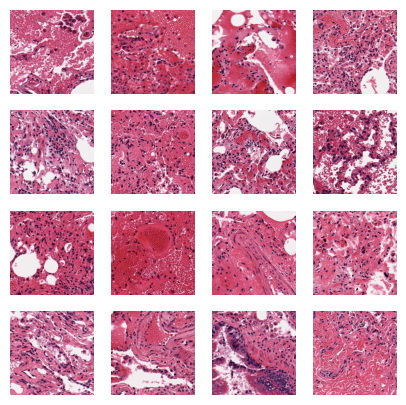

In [19]:
batch = next(iter(generator_train))
images = batch[0]

grid_size = 4

plt.figure(figsize=(5, 5))

for i in range(grid_size * grid_size):
    img = images[i]

    # Normalize if the images are between -1 and 1
    if img.min() < 0:
        img = (img + 1) / 2

    # Ensure the image is uint8
    if img.dtype != 'uint8':
        img = (img * 255).astype('uint8')

    plt.subplot(grid_size, grid_size, i + 1)
    plt.imshow(img)
    plt.axis('off')

plt.show()


## Get Weights

In [20]:
if weighted:
    if train_classes == ['Smoker', 'Non Smoker']:
        weights = md.calculate_class_weights(df_train_tiles['smoker_status'].values, multiplier_factor)
        #df_train_tiles["weights"] = df_train_tiles.target.map(weights_)
    else:
        print("[-] Weights were only implemented for binary classification of Smoker and Non Smoker classes.")
        weights = None
else:
    weights = None

## Model training

In [21]:
from keras.optimizers import Adam

model = md.setup_model(model_type, input_shape=(SIZE[0], SIZE[1], 3))
optimizer = Adam(learning_rate=learning_rate)
model.compile(
    optimizer=optimizer, 
    loss='binary_crossentropy', 
    metrics=['AUC', 'Recall', 'Precision',  md.keras_f1_score, 'accuracy']
    )

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 16, 16, 2048)      20861480  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 20863529 (79.59 MB)
Trainable params: 20809001 (79.38 MB)
Non-trainable params: 54528 (213.00 KB)
_________________________________________________________________


None


In [22]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor='val_auc')

In [23]:
model.fit(
    generator_train, 
    epochs           = epochs,
    steps_per_epoch  = len(generator_train),
    validation_steps = steps_valid,
    validation_data  = generator_valid,
    class_weight     = weights,
    callbacks        = [early_stopping],
    )

Epoch 1/10


2023-12-19 22:19:04.802556: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


  10/2170 [..............................] - ETA: 1:44:41 - loss: 0.9206 - auc: 0.5016 - recall: 0.5000 - precision: 0.1413 - keras_f1_score: 0.2042 - accuracy: 0.4250

# PART 4 - Predicting

In [ ]:
predictions_test = []
labels_test = []
for batch_X_test, batch_y_test in generator_test:
    batch_predictions_test = model.predict(batch_X_test)
    predictions_test.extend(batch_predictions_test)
    labels_test.append(batch_y_test)
    if len(predictions_test) >= len(df_train_tiles):
        break

In [ ]:
ar_predictions_test = np.concatenate(predictions_test)
df_train_tiles['pred_probs'] = ar_predictions_test
classes = np.where(ar_predictions_test > 0.5, 1, 0)
df_train_tiles['pred'] = classes

# PART 5 - Evaluating

In [ ]:
# Evaluation: Tile level
df_train_tiles['true'] = df_train_tiles['smoker_status'].map({'non-smoker':0, 'smoker':1})
plot_cm(df_train_tiles, col_true='true', col_pred='pred', title='tileLevel')
plot_roc_curve(df_train_tiles['true'], df_train_tiles['pred_probs'], 'tileLevel', model_type)
metrics_tile = classification_metrics(df_train_tiles['true'], df_train_tiles['pred'], df_train_tiles['pred_probs'], 'tile')

# Evaluation: Subject level
df_preds_subject_level = df_train_tiles.groupby(['sample_id', 'true'])['pred'].apply(lambda x: x.mode()[0]).reset_index()
plot_cm(df_preds_subject_level, col_true='true', col_pred='pred', title='subjLevel')
se_subj_pred = df_preds_subject_level['pred']
df_preds_subject_level = df_train_tiles.groupby(['sample_id', 'true'])['pred_probs'].apply(lambda x: x.median()).reset_index()
plot_roc_curve(df_preds_subject_level['true'], df_preds_subject_level['pred_probs'], 'subjLevel', model_type)
metrics_subject = classification_metrics(df_preds_subject_level['true'], se_subj_pred, df_preds_subject_level['pred_probs'], 'subj')